In [1]:
import os
import pandas as pd
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from adjustText import adjust_text

In [2]:
# declare CSV variable names
# change to computer file path and add the title 'ModelID' to first column of CRISPRGeneEffect.csv
pd.options.display.max_rows = 99999
pd.options.display.max_columns = 99999
model = '/Users/connormullins/Excel sheets/Model.csv'
osm = '/Users/connormullins/Excel sheets/OmicsSomaticMutations.csv'
effect = '/Users/connormullins/Excel sheets/CRISPRGeneEffect.csv'

In [3]:
# convert CSVs to pandas dataframes
model_df = pd.read_csv(model, header=0, index_col=0)
osm_df = pd.read_csv(osm, header=0)
effect_df = pd.read_csv(effect, header=0, index_col=0)

/var/folders/k9/bz30f50d0bv1pzq8kv4wkg4h0000gn/T/ipykernel_26277/3585096085.py:3: DtypeWarning: Columns (20,48,52,54,55,56,57,59) have mixed types. Specify dtype option on import or set low_memory=False.
  osm_df = pd.read_csv(osm, header=0)


In [16]:
# filter model.csv to only keep indices which contain cancer type declared
cancer = "Non-Small Cell Lung Cancer"
filter_model = model_df[model_df["OncotreePrimaryDisease"] == cancer]
# filter the OmicsSomaticMutations.csv to only include model ids that have declared cancer type
osm_filter = pd.merge(filter_model, osm_df, on=['ModelID'], how='inner')
# filter that dataframe to only include the gene and mutation declared
gene = 'KRAS'
mutation = "p.G12C"
osm_gene_filter = osm_filter[(osm_filter['HugoSymbol'] == gene)]
osm_mutant_filter = osm_gene_filter[(osm_gene_filter['ProteinChange'] == mutation)]

In [17]:
# filter such that another dataframe is created for all modelIDs that have a mutation in another gene
# if there is a gene change in the second protein 'is_gene_change' should = True
cancer_2 = "Non-Small Cell Lung Cancer"
filter_model_2 = model_df[model_df["OncotreePrimaryDisease"] == cancer_2]
comutation_gene = "KRAS"
osm_filter_2 = pd.merge(filter_model_2, osm_df, on=['ModelID'], how='inner')
osm_comutant = osm_filter_2[(osm_filter_2['HugoSymbol'] == comutation_gene)]

is_gene_change = True

if is_gene_change == False:
    pass
else:
    comutation_change = "p.Q61H"
    osm_comutant_filter = osm_comutant[(osm_comutant['ProteinChange'] == comutation_change)]

In [18]:
# compare the two dataframes. The models that have a mutation for both the gene and comutant gene will be in a comutant dataframe.
# the models that only have the gene mutation will be under no_comutation
# if there is a comutation, comutation = True, if not comutation = False
comutation = False

if comutation == True:
    comutant = osm_mutant_filter.merge(osm_comutant, on=['ModelID'], how='inner')
    no_comutant = osm_mutant_filter.merge(osm_comutant, on=['ModelID'], how='left')

else:
    comutant = osm_comutant_filter
    no_comutant = osm_mutant_filter

In [19]:
# merge the left and inner parts to make a new merged dataframe with duplicates of the comutants that can be dropped
no_comutant = pd.concat([no_comutant, comutant])
no_comutant = no_comutant.drop_duplicates(keep =  False)
# filter the dataframes just created to only include the model ids of the ones that match the parameters
comutant_filter = comutant.filter(['ModelID'])
no_comutant_dropped = no_comutant.filter(['ModelID'])

In [20]:
# using CRISPRGeneEffect.csv, filter into two dataframes for mutant and comutant and average the values over the row
comutant_effect = comutant_filter.merge(effect_df, on=['ModelID'], how='inner')
comutant_effect = comutant_effect.set_index('ModelID')

comutant_effect = comutant_effect.drop_duplicates(keep =  False)
no_comutant_effect = no_comutant_dropped.merge(effect_df, on=['ModelID'], how='left')
no_comutant_effect = no_comutant_effect.set_index('ModelID')
no_comutant_effect = no_comutant_effect.drop_duplicates(keep =  False)

In [21]:
# t-test to get p-values
p_val = scipy.stats.ttest_ind(no_comutant_effect, comutant_effect, axis = 0, equal_var = True, nan_policy = 'omit')
pvalue = p_val.pvalue

In [22]:
# convert pvalues to be used for yaxis
yaxis = -np.emath.logn(10, pvalue)
yaxis = pd.DataFrame(yaxis)
yaxis.rename(columns = {0 : 'nlogpvalue'}, inplace =True)

In [23]:
# find the mean of the dataframes
comutant_mean = comutant_effect.mean(axis = 0, skipna = True)
comutant_mean = comutant_mean.reset_index(drop = True)
no_comutant_mean = no_comutant_effect.mean(axis = 0, skipna = True)
no_comutant_mean = no_comutant_mean.reset_index(drop = True)

In [24]:
# calculate fold change and log2fold change... this applies missing values to negatives
fold_change =  comutant_mean / no_comutant_mean

xaxis = np.log2(fold_change)
xaxis = pd.DataFrame(xaxis)
xaxis.rename(columns = {0 : 'log2FC'}, inplace= True)

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
# create dataframe that will be plotted on volcano plot
volcano = pd.concat([xaxis, yaxis], axis =1)
volcano = volcano.set_index(no_comutant_effect.columns)
volcano = volcano.reset_index()
volcano.rename(columns = {'index' : 'symbol'}, inplace =True)

([Text(-5.474678554641368, 1.4710332620283026, 'ACTR2 (10097)'),
  Text(-11.12431844438704, 1.4706339277628675, 'ADGRL4 (64123)'),
  Text(7.371696673536459, 1.7765155509647488, 'AMPD2 (271)'),
  Text(-4.914213305525024, 1.5688775859629929, 'APH1A (51107)'),
  Text(-7.3722997689920415, 1.3987119045970486, 'ARPC4 (10093)'),
  Text(5.331796798156756, 1.4455686337623166, 'BAG5 (9529)'),
  Text(7.369403129399387, 1.6557263280540604, 'BAIAP3 (8938)'),
  Text(-11.2093245248582, 1.6000839114462626, 'CDC42 (998)'),
  Text(2.8089821838726223, 1.6012101119217577, 'CIT (11113)'),
  Text(1.873785753029967, 1.7765155509647488, 'DHX33 (56919)'),
  Text(11.66808190777066, 1.5728264877497888, 'EPB41L4A (64097)'),
  Text(1.2191478874577655, 1.688307502698617, 'FAM210A (125228)'),
  Text(-1.3783949751845412, 1.3806302880344192, 'FETUB (26998)'),
  Text(12.084263503421443, 1.7314886824814724, 'GUCY2C (2984)'),
  Text(-3.0179717129600707, 1.6291548904740265, 'IDI1 (3422)'),
  Text(-7.56570773095007, 1.6858

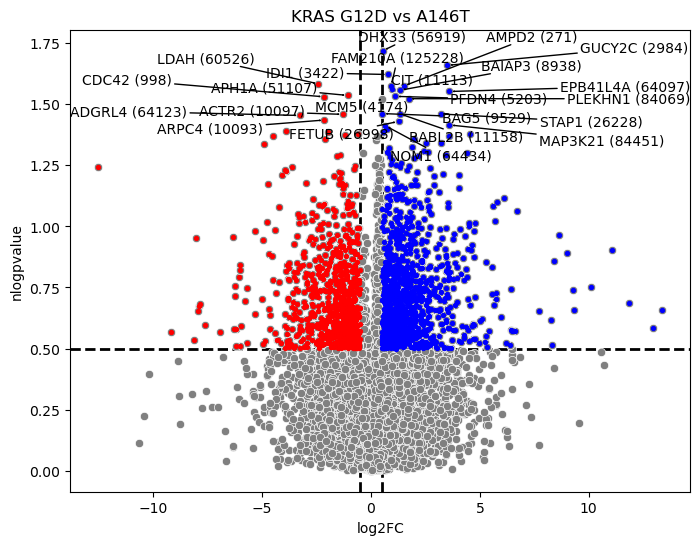

In [26]:
# actually plotting it now

plt.figure(figsize = (8, 6))
point_size = 8
ax = sns.scatterplot(data = volcano, x = 'log2FC', y = 'nlogpvalue', c = 'gray')

ax.axhline(0.5, zorder = 0, c = 'k', lw = 2, ls = '--')
ax.axvline(0.5, zorder = 0, c = 'k', lw = 2, ls = '--')
ax.axvline(-0.5, zorder = 0, c = 'k', lw = 2, ls = '--')




# Conditions for coloring
condition1 = (volcano['nlogpvalue'] > 0.5) & (volcano['log2FC'] > 0.5)
condition2 = (volcano['nlogpvalue'] > 0.5) & (volcano['log2FC'] < -0.5)

# Apply color based on conditions
ax.scatter(volcano.loc[condition1, 'log2FC'], volcano.loc[condition1, 'nlogpvalue'], c='blue', s = point_size)
ax.scatter(volcano.loc[condition2, 'log2FC'], volcano.loc[condition2, 'nlogpvalue'], c='red', s = point_size)

texts = []

# change values in this if statement to fit the values in the plot so it looks nice and not cluttered
for i in range(len(volcano)):
    if volcano.iloc[i].nlogpvalue > 1.4 and (volcano.iloc[i].log2FC > 3 or volcano.iloc[i].log2FC < 3):
        texts.append(plt.text(volcano.iloc[i].log2FC, y = volcano.iloc[i].nlogpvalue, s = volcano.iloc[i].symbol))

# change the title of the plot here
plt.title('KRAS G12D vs A146T')
adjust_text(texts, arrowprops = dict(arrowstyle = '->', color = 'k'))